In [1]:
import re
import numpy as np
import pandas as  pd
from pprint import pprint# Gensim
import gensim
import gensim.corpora as corpora
import gensim.models as genmodels
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import pickle
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt

D:\Eskwelabs\sprint4\dsf-c10-sprint-4\code-along\scripting_101\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [3]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')


#stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [4]:
df = pickle.load(open("../data/merged_hotel_data.pkl", "rb"))
df=df.replace(r'^\s*$', np.nan, regex=True)
print(df.shape)
#df.head()


(76536, 30)


In [8]:
default_comments=["There are no comments available for this review"]

pattern = '|'.join(default_comments)
df_reviews_sr=df[["positive_review"]].dropna()
df_reviews_sr=df_reviews_sr[~df_reviews_sr.positive_review.str.contains(pattern)]
df_reviews_sr

,positive_review
0,I like The place and also the staff they're so...
1,location
2,The location
3,Its Near my work area
4,The location
...,...
76434,it’s looks great in the photos but it’s not as...
76435,the staff were all nice and friendly. great se...
76436,Room is big
76437,Staff are friendly and helpful. The room is cl...


In [10]:
# Convert to list 
data = df_reviews_sr.positive_review.values.tolist()  
# # Remove Emails 
# data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]  
# # Remove new line characters 
# data = [re.sub('\s+', ' ', sent) for sent in data]  
# # Remove distracting single quotes 
# data = [re.sub("\'", "", sent) for sent in data]
# #Remove \n
# data = [re.sub("\n", "", sent) for sent in data]
# data = [re.sub("(Image courtesy: )", "", sent) for sent in data]
# #Remove links
# data = [re.sub(r'http\S+', '', sent) for sent in data]
display(len(data))
print(data[8])

29492

I booked the location near my residence, but later I was transferred to location with accredited for quarantine. But anyhow, it is a enjoyable stay in your nice hotel! Thank you!


### Tokenization

In [11]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))            #deacc=True removes punctuations

data_words = list(sent_to_words(data))
print(data_words[:9]) 

[['like', 'the', 'place', 'and', 'also', 'the', 'staff', 'they', 're', 'so', 'active', 'when', 'im', 'needed', 'something', 'the', 'receptionist', 'also', 'also', 'go', 'back', 'there', 'when', 'have', 'work', 'in', 'east', 'ave', 'thanks', 'so', 'much', 'for', 'they', 're', 'kindness'], ['location'], ['the', 'location'], ['its', 'near', 'my', 'work', 'area'], ['the', 'location'], ['big', 'room'], ['it', 'was', 'located', 'near', 'east', 'ave', 'med', 'center', 'and', 'phc', 'walking', 'distance', 'to', 'these', 'hospitals'], ['reasonable', 'price', 'bug', 'room'], ['booked', 'the', 'location', 'near', 'my', 'residence', 'but', 'later', 'was', 'transferred', 'to', 'location', 'with', 'accredited', 'for', 'quarantine', 'but', 'anyhow', 'it', 'is', 'enjoyable', 'stay', 'in', 'your', 'nice', 'hotel', 'thank', 'you']]


### Building the bigram and trigram Models

In [12]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)


In [13]:
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[8]]])

['booked', 'the', 'location', 'near', 'my', 'residence', 'but', 'later', 'was', 'transferred', 'to', 'location', 'with', 'accredited', 'for', 'quarantine', 'but', 'anyhow', 'it', 'is', 'enjoyable', 'stay', 'in', 'your', 'nice', 'hotel', 'thank', 'you']


### Define function for stopwords, bigrams, trigrams and lemmatization

In [15]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [16]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
data_words_trigrams = make_trigrams(data_words_nostops)


In [17]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en

#nlp = spacy.load('en_core_web_lg')
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])


# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized_bi = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
data_lemmatized_tri = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized_bi[-1])

D:\Eskwelabs\sprint4\dsf-c10-sprint-4\code-along\scripting_101\lib\site-packages\spacy\language.py:1895: UserWarning: [W123] Argument disable with value ['parser', 'ner'] is used instead of ['senter'] as specified in the config. Be aware that this might affect other components in your pipeline.
  warnings.warn(


['superior', 'room', 'bathroom', 'small', 'shower', 'area', 'small', 'compare', 'previous', 'standard', 'room', 'lot', 'mosquitos', 'bathroom', 'smell', 'disinfect', 'clean', 'thorougly']


In [22]:
len(data_lemmatized_bi)

29492

In [23]:
id2word_bi = corpora.Dictionary(data_lemmatized_bi)  
id2word_tri = corpora.Dictionary(data_lemmatized_tri)  

In [24]:
texts_bi = data_lemmatized_bi
texts_tri = data_lemmatized_tri

In [25]:
# Term Document Frequency 
corpus_bi = [id2word_bi.doc2bow(text) for text in texts_bi]  
corpus_tri = [id2word_tri.doc2bow(text) for text in texts_tri]  

In [26]:
# View 
print(corpus_bi[:8])

[[(0, 1), (1, 3), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1)], [(15, 1)], [(15, 1)], [(14, 1), (16, 1)], [(15, 1)], [(17, 1), (18, 1)], [(2, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1)], [(18, 1), (24, 1), (25, 1), (26, 1)]]


In [27]:
[[(id2word_bi[id], freq) for id, freq in cp] for cp in corpus_bi[:1]]
[[(id2word_tri[id], freq) for id, freq in cp] for cp in corpus_tri[:1]]

[[('active', 1),
  ('also', 3),
  ('ave', 1),
  ('back', 1),
  ('east', 1),
  ('go', 1),
  ('kindness', 1),
  ('m', 1),
  ('much', 1),
  ('need', 1),
  ('place', 1),
  ('receptionist', 1),
  ('staff', 1),
  ('thank', 1),
  ('work', 1)]]

<AxesSubplot: ylabel='word'>

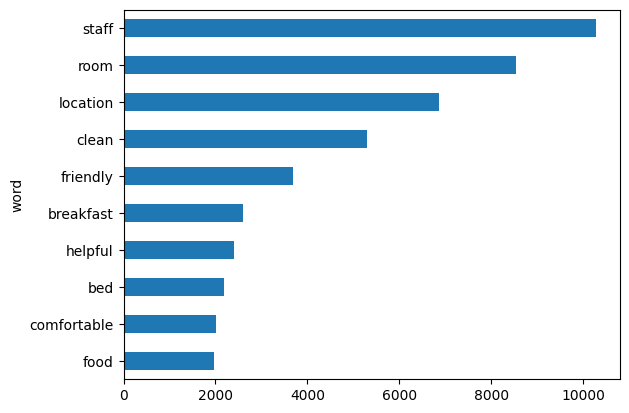

In [28]:
bow=[[(id2word_tri[id], freq) for id, freq in cp] for cp in corpus_tri]
flat_list = [item for sublist in bow for item in sublist]


no_value_words=["stay","good","hotel","place","nice","great"]

df_bow = pd.DataFrame(flat_list, columns = ['word', 'count'])
df_bow=df_bow[~df_bow.word.str.contains('|'.join(no_value_words))] 
df_bow.groupby("word")["count"].sum().sort_values(ascending=True).tail(10).plot.barh()

### LSI & LDA Model

In [22]:
def model_competition(corpus,id2word,data_lemmatized):
    random_state = 100
    for_framing = []
    
    algo_names = ["LDA Model","LSI Model",]
    algorithms = [genmodels.ldamodel.LdaModel,genmodels.lsimodel.
                  LsiModel]
    
    for algo_name, algorithm in zip(algo_names, algorithms):
        for k in range(1, 11):
            if algo_name == 'LDA Model':
                model = algorithm(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=k, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        
                perplexity = model.log_perplexity(corpus)
                coherence_model = CoherenceModel(model=model, texts=data_lemmatized, 
                               dictionary=id2word, coherence='c_v')
                coherence = coherence_model.get_coherence()
            if algo_name == 'LSI Model':
                model = algorithm(corpus=corpus,
                                  id2word=id2word,
                                  num_topics=k,
                                  chunksize=100)
        
                coherence_model = CoherenceModel(model=model, texts=data_lemmatized, 
                               dictionary=id2word, coherence='c_v')
                coherence = coherence_model.get_coherence()
        
            data_row = {
                'model': algo_name,
                'topic count' : k,
                'coherence' : coherence
            }
            for_framing.append(data_row)
        
    return pd.DataFrame(for_framing)
        
        
    

In [ ]:
bigram_dataframe = model_competition(corpus_bi,id2word_bi,data_lemmatized_bi)

In [58]:
bigram_dataframe.sort_values(by=['coherence'],ascending=False).head(1)

,model,topic count,coherence
8,LDA Model,9,0.604526


In [59]:
trigram_dataframe = model_competition(corpus_tri,id2word_tri,data_lemmatized_tri)

In [60]:
trigram_dataframe.sort_values(by=['coherence'],ascending=False).head(1)

,model,topic count,coherence
8,LDA Model,9,0.604363


# HDP

In [19]:
hdpmodel =  gensim.models.hdpmodel.HdpModel(corpus=corpus_bi, id2word=id2word_bi)
coherence_model_hdpmodel = CoherenceModel(model=hdpmodel, texts=data_lemmatized_bi, dictionary=id2word_bi, coherence='c_v')
coherence_hdpmodel = coherence_model_hdpmodel.get_coherence()
print('\nCoherence Score: ', coherence_hdpmodel)


Coherence Score:  0.543526652939898


In [21]:
hdpmodel.show_topics()

[(0,
  '0.015*datum + 0.010*model + 0.009*use + 0.005*data + 0.005*time + 0.005*learn + 0.005*make + 0.005*also + 0.004*image + 0.004*dataset + 0.004*need + 0.004*create + 0.004*value + 0.004*learning + 0.004*get + 0.004*function + 0.004*feature + 0.004*code + 0.004*work + 0.003*example'),
 (1,
  '0.019*datum + 0.009*model + 0.009*data + 0.007*use + 0.007*science + 0.006*learn + 0.006*work + 0.005*time + 0.005*value + 0.004*get + 0.004*make + 0.004*learning + 0.004*project + 0.004*machine + 0.004*good + 0.004*well + 0.004*need + 0.003*find + 0.003*also + 0.003*feature'),
 (2,
  '0.014*datum + 0.010*model + 0.009*use + 0.006*learn + 0.006*learning + 0.006*data + 0.005*function + 0.005*value + 0.005*time + 0.005*image + 0.004*create + 0.004*feature + 0.004*also + 0.004*dataset + 0.004*let + 0.004*make + 0.004*work + 0.004*see + 0.003*need + 0.003*machine'),
 (3,
  '0.009*datum + 0.007*use + 0.006*time + 0.006*code + 0.005*value + 0.004*function + 0.004*create + 0.004*need + 0.004*get + 0

In [22]:
hdpmodel_tri =  gensim.models.hdpmodel.HdpModel(corpus=corpus_tri, id2word=id2word_tri)
coherence_model_hdpmodel_tri = CoherenceModel(model=hdpmodel_tri, texts=data_lemmatized_tri, dictionary=id2word_tri, coherence='c_v')
coherence_hdpmodel_tri = coherence_model_hdpmodel_tri.get_coherence()
print('\nCoherence Score: ', coherence_hdpmodel_tri)


Coherence Score:  0.5348782847089283


In [23]:
hdpmodel_tri.show_topics()

[(0,
  '0.017*datum + 0.010*model + 0.009*use + 0.007*data + 0.006*time + 0.006*learn + 0.005*value + 0.005*learning + 0.004*make + 0.004*work + 0.004*also + 0.004*code + 0.004*image + 0.004*function + 0.004*need + 0.004*get + 0.004*science + 0.004*example + 0.004*well + 0.004*feature'),
 (1,
  '0.008*model + 0.008*use + 0.007*datum + 0.006*python + 0.005*dataset + 0.005*user + 0.005*function + 0.005*create + 0.004*new + 0.004*project + 0.004*method + 0.004*want + 0.004*get + 0.004*see + 0.004*time + 0.004*need + 0.004*make + 0.003*also + 0.003*learn + 0.003*work'),
 (2,
  '0.011*model + 0.010*datum + 0.007*use + 0.005*value + 0.005*image + 0.004*word + 0.004*make + 0.004*work + 0.004*data + 0.004*training + 0.003*time + 0.003*learning + 0.003*learn + 0.003*well + 0.003*also + 0.003*feature + 0.003*number + 0.003*set + 0.003*good + 0.003*dataset'),
 (3,
  '0.015*datum + 0.008*data + 0.007*learn + 0.006*science + 0.005*work + 0.004*job + 0.004*get + 0.004*need + 0.004*use + 0.004*help +